In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gensim
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import relevant libraries
import re
import random
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm

# import nltk and gensim library for token level embeddings
import nltk
import gensim
from nltk.data import find


In [ ]:
print('GPU name: ', tf.config.list_physical_devices('GPU'))
DATA_DIR = "/content/drive/MyDrive/w266-finalproj/data"

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Model Training

In [ ]:
# instantiate Word2Vec token level embedding
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [ ]:
#@title Embedding Matrix Creation
# let's try 300 dimension Word2Vec Embedding
EMBEDDING_DIM = 300

# initialize embedding matrix and word-to-id map:
# embedding_matrix = np.zeros((len(model.key_to_index) + 1, EMBEDDING_DIM))       
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       

vocab_dict = {}

# build the embedding matrix and the word-to-id map:
# for i, word in enumerate(model.key_to_index):
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)
embedding_matrix.shape

(43982, 300)

In [ ]:
embedding_matrix

array([[ 0.0891758 ,  0.121832  , -0.0671959 , ..., -0.0480419 ,
        -0.0277889 ,  0.0872918 ],
       [ 0.0526281 ,  0.013157  , -0.010104  , ...,  0.0209349 ,
        -0.0537912 ,  0.0654217 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 , ..., -0.00832253,
        -0.00398034, -0.0825016 ],
       ...,
       [ 0.0887422 ,  0.0537124 ,  0.0467064 , ..., -0.0794009 ,
         0.0945805 , -0.0361975 ],
       [-0.011512  ,  0.0173624 , -0.0364862 , ..., -0.0425253 ,
         0.0231499 , -0.014217  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
pop_data = pd.read_csv(f"{DATA_DIR}/02_intermediate/rap_sample.csv")
pop_data = pop_data.loc[:, ~pop_data.columns.str.contains('^Unnamed')]
# pop_data = pop_data[:1000]
pop_data

,artist,genre,title,lyrics,word_num,language
0,Lil Skies,Rap,Ball Everyday*,Lyrics from Snippet\n\nThey all gon' sing alon...,126,en
1,50 Cent,Rap,My Gun Go Off,"Nigga, my gun go off - you see the barrel turn...",581,en
2,OutKast,Rap,Elevators (Me & You) (Crazy ‘C’ Trunk Rattlin’...,"One for the money, yes, sir, two for the show\...",749,en
3,Ski Mask the Slump God,Rap,Cat Piss,"Deko\nHaha, ahem, yeah\nOG Parker\nHahaha\nMan...",520,en
4,Kendrick Lamar,Rap,West Coast Wu-Tang,Whoo Ha!\nBackpack raps with gats in it\nDon't...,981,en
...,...,...,...,...,...,...
5995,Migos,Rap,Supastars,"(Honorable C.N.O.T.E.)\nYeah, yeah\nYeah (Budd...",930,en
5996,Kid Cudi,Rap,Highs N’ Lows,I be high when I split a dutch and fill it up\...,707,en
5997,Logic,Rap,Street Dreams II,"Uh, suddenly I'm in the whip, with the gat, fu...",1030,en
5998,DaBaby,Rap,Jesus III,One shoebox full of mula (Jeez)\nI been stack...,655,en


In [ ]:
# Define Hard Code Max Sequence Length
MAX_SEQUENCE_LENGTH = 16

# define some preprosessing functions
# training data processing
stopChars = [',','(',')','.','-','[',']','"']

# preprocessing the corpus by converting all letters to lowercase, 
# replacing blank lines with blank string and removing special characters
def preprocessText(text):
    processedText = text.lower()
    for char in stopChars:
        processedText = processedText.replace(char,'')
    return processedText

# tokenization 
def corpusToList(corpus):
    corpusList = [w for w in corpus.split(' ')] 
    corpusList = [i for i in corpusList if i] #removing empty strings from list
    return corpusList
    

def tokenize_data(data):
    data = data.copy()
    word_list = []
    for i, row in data.iterrows():
        lyric = row['lyrics']
        lyric = lyric.replace('\n', ' \n ')
        lyric = lyric.replace('!', ' ! ')
        lyric = lyric.replace('?', ' ? ')
        lyric = lyric.replace('#', ' ')
        lyric = re.findall(r'\S+|\n', lyric)
        word_list.append(lyric)
    # concatenating the word list to create a corpus
    DP_text = [j for i in word_list for j in i]
    print('corpus length:', len(DP_text))
    return(DP_text)

# Create a dictionary of characters, see the index of characters.
def dictionary_maker(words):
    char_to_int = dict((c, i) for i, c in enumerate(words))
    int_to_char = dict((i, c) for i, c in enumerate(words))
    char_to_int['UNK'] = len(int_to_char)
    int_to_char[len(int_to_char)] = 'UNK'
    return(char_to_int, int_to_char)


def make_sentences_and_next_chars(seq_length, DP_text, step):
    sentences = []
    next_chars = []

    # Create Target and sentences window
    for i in range(0, len(DP_text) - seq_length, step):
        # range from current index to sequence length charaters
        sentences.append(DP_text[i: i + seq_length])  
        next_chars.append(DP_text[i + seq_length]) # the next character
    
    sentences = np.array(sentences)
    next_chars = np.array(next_chars)
    return(sentences, next_chars)

In [ ]:
DP_pop = tokenize_data(pop_data)
pop_words = sorted(list(set(DP_pop)))
pop_char_to_int, pop_int_to_char = dictionary_maker(pop_words)
pop_sentences, pop_next_chars = make_sentences_and_next_chars(MAX_SEQUENCE_LENGTH, DP_pop, 1)

corpus length: 3798168


In [ ]:
len(pop_words)

112549

# Generate Training Data
Generate X faetures and y target for text generation model

In [ ]:
def getdata(sentences, next_chars, seq_length, char_to_int):
    """
        Create a sequence of n character as features X
        Use next character as target y
        TODO: clean this up
    """
    X = np.zeros((len(sentences),seq_length))
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char_to_int[char]
        y[i] = char_to_int[next_chars[i]]
    return X, y

In [ ]:
# create train faetures and word output
x_train, y_train = getdata(pop_sentences, pop_next_chars, MAX_SEQUENCE_LENGTH, pop_char_to_int)
print(x_train, y_train)

[[ 32968.  71376.  43599. ...  68039.  95982. 111302.]
 [ 71376.  43599.      0. ...  95982. 111302. 108933.]
 [ 43599.      0.      0. ... 111302. 108933.  91796.]
 ...
 [ 86850. 104203.  87318. ...  81621. 103401.  56392.]
 [104203.  87318. 106408. ... 103401.  56392. 104116.]
 [ 87318. 106408. 105166. ...  56392. 104116.  71944.]] [108933.  91796. 111302. ... 104116.  71944.  97620.]


# Baseline LSTM
Simple LSTM architecture with an extra hidden layer

In [ ]:
# Design Neural Network without Attention
def baseline_LSTM(lstm_dim,
                dense_layer_dim,
                dropout_rate=0.2):
    """
        LSTM Layer with attention
    """
    
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # declare a source input
    # apply embedding layer to the input
    source_input_no_att = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), 
                                                  dtype='int64', 
                                                  name='source_input_no_att')
    

    source_embeddings_no_att = tf.keras.layers.Embedding(input_dim = embedding_matrix.shape[0],
                                                          output_dim = embedding_matrix.shape[1],
                                                          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                          input_length=MAX_SEQUENCE_LENGTH,
                                                          trainable=False, 
                                                          name = 'source_embedding_layer_no_att')
    
    src_embedding = source_embeddings_no_att(source_input_no_att)
    
    # LSTM layer
    encoder_lstm_layer_with_att = tf.keras.layers.LSTM(lstm_dim, 
                                                       return_sequences=False, 
                                                       return_state=False, 
                                                       recurrent_dropout=dropout_rate,
                                                       name='LSTM_Layer')
    encoder_out_with_att = encoder_lstm_layer_with_att(src_embedding)
    last_hidden_output = encoder_out_with_att

    # add 1 dense layer (later?)
    last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)

    lstm_prediction = keras.layers.Dense(len(pop_words), activation='softmax')(last_hidden_output)

    lstm_model = keras.Model(inputs=source_input_no_att, outputs=lstm_prediction)
    lstm_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return lstm_model

In [ ]:
lstm_model = baseline_LSTM(
                lstm_dim=256,
                dense_layer_dim=256,
                dropout_rate=0.2)
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_input_no_att (InputL  [(None, 16)]             0         
 ayer)                                                           
                                                                 
 source_embedding_layer_no_a  (None, 16, 300)          13194600  
 tt (Embedding)                                                  
                                                                 
 LSTM_Layer (LSTM)           (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 112549)            289250

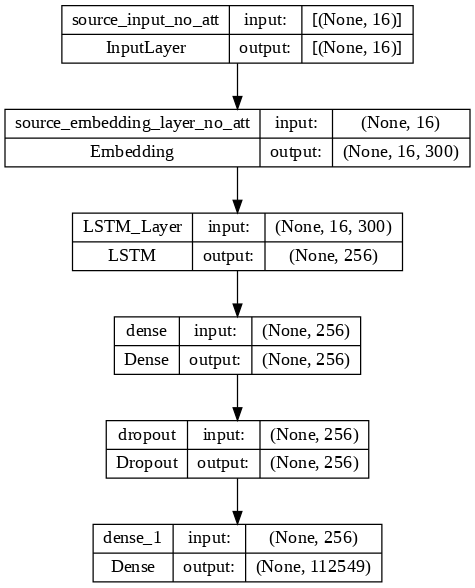

In [ ]:
keras.utils.plot_model(lstm_model, show_shapes=True, dpi=90)

In [ ]:
lstm_history = lstm_model.fit(x_train,
                            y_train,
                            validation_split=0.1,
                            batch_size=258,
                            epochs=20)

Epoch 1/20
13250/13250 [==============================] - 1109s 83ms/step - loss: 6.6080 - accuracy: 0.1291 - val_loss: 6.5272 - val_accuracy: 0.1362
Epoch 2/20
13250/13250 [==============================] - 1108s 84ms/step - loss: 6.3673 - accuracy: 0.1364 - val_loss: 6.4789 - val_accuracy: 0.1404
Epoch 3/20
13250/13250 [==============================] - 1095s 83ms/step - loss: 6.2664 - accuracy: 0.1399 - val_loss: 6.4721 - val_accuracy: 0.1425
Epoch 4/20
13250/13250 [==============================] - 1090s 82ms/step - loss: 6.1921 - accuracy: 0.1428 - val_loss: 6.4565 - val_accuracy: 0.1442
Epoch 5/20
13250/13250 [==============================] - 1088s 82ms/step - loss: 6.1308 - accuracy: 0.1453 - val_loss: 6.4538 - val_accuracy: 0.1446
Epoch 6/20
13250/13250 [==============================] - 1086s 82ms/step - loss: 6.0763 - accuracy: 0.1475 - val_loss: 6.4698 - val_accuracy: 0.1455
Epoch 7/20
13250/13250 [==============================] - 1086s 82ms/step - loss: 6.0282 - accuracy:

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds[0], 1)
    return np.argmax(probas)

In [ ]:
# Define the start sentence
# sentence = 'i read in the news\nthat the average man\nplease kis'
# load model params:
# lstm_model = baseline_LSTM(lstm_dim=256,
#                 dense_layer_dim=256,
#                 embedding_input_dim=37261,
#                 embedding_output_dim=256,
#                 dropout_rate=0.2,
#                 embeddings_trainable=False)

# lstm_model.load_weights('../data/03_model_training/weights-improvement-20-3.3095-bigger.hdf5')

seq_length = 16
char_to_int = pop_char_to_int
int_to_char = pop_int_to_char
sentence = ["there's", "two", "things", "\n",
            "that", "i", 'have', "yet", "to", "learn", "\n",
            "how", "to", "forget", "or", "\n"]

variance = .5
generated = []
original = sentence
window = sentence

for i in tqdm(range(100)):
    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = char_to_int[char] # Change the sentence to index vector shape (1,50)
        
    x_in = x
    pred = lstm_model(x_in)
    next_index = sample(pred, variance)
    next_char = int_to_char[next_index] # index to char
    generated = generated + [next_char]
    window = window[1:] + [next_char] # Update Window for next char predict
print(" ".join(original + generated))
    

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


there's two things 
 that i have yet to learn 
 how to forget or 
 We your 
 Woah, yeah, 
 
 I know it like 
 I love know a 
 I feel the you 
 I don't it I'm not 
 I got it 
 I'm just in 
 
 I got not I'm a 
 I can't never 
 
 I got I just I know lyin', I know, 
 I got I know, I know, 
 I dedicate, I know, I know, I know, 
 I know, I know, I know, I know, I know, 
 I know I know, I know, I know, I know, I know, I know, 



In [ ]:
# save model weights
lstm_model.save_weights(f"{DATA_DIR}/03_model_training/rap_lstm_baseline.h5")

# Self-Attention Seq2Seq
Implementation of MultiHeaded Self Attention to baseline LSTM

In [ ]:
# Design Neural Network without Attention
def multiheaded_attention_lstm(lstm_dim,
                               dense_layer_dim,
                               num_heads,
                               key_dim,
                               dropout_rate=0.2):
    """
        LSTM Layer with multiheaded self-attention
    """
    
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # declare a source input
    # apply embedding layer to the input
    source_input_with_att = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), 
                                                  dtype='int64', 
                                                  name='source_input_with_att')
    

    source_embeddings_with_att = tf.keras.layers.Embedding(input_dim = embedding_matrix.shape[0],
                                                          output_dim = embedding_matrix.shape[1],
                                                          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                          input_length=MAX_SEQUENCE_LENGTH,
                                                          trainable=False, 
                                                          name = 'source_embedding_layer_wit_att')

    src_embedding = source_embeddings_with_att(source_input_with_att)

    # define the lstm layer
    encoder_lstm_layer_with_att = tf.keras.layers.LSTM(embedding_matrix.shape[1], return_sequences=True, return_state=True, recurrent_dropout=dropout_rate,name='LSTM_Layer')
    encoder_out_with_att, encoder_state_h_with_att, encoder_state_c_with_att = encoder_lstm_layer_with_att(src_embedding)

    attention_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                        key_dim=key_dim, 
                                                        dropout=dropout_rate,
                                                        name = 'attention_layer')
    context_vector = attention_layer(encoder_out_with_att, encoder_out_with_att)

    # reshape the context vector:
    context_vector = tf.keras.layers.GlobalAveragePooling1D()(context_vector)
    
    # concatenate the context vector and query vector
    # Attention Mechanism to be feed into a fully connected Neural Net
    input_layer = tf.keras.layers.Concatenate()([context_vector, encoder_state_h_with_att])
    last_hidden_output = input_layer

    # add 1 dense layer (later?)
    last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)

    lstm_prediction = keras.layers.Dense(len(pop_words), activation='softmax')(last_hidden_output)

    lstm_model = keras.Model(inputs=source_input_with_att, outputs=lstm_prediction)
    lstm_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return lstm_model

In [ ]:
attention_lstm_model = multiheaded_attention_lstm(lstm_dim=256,
                                        dense_layer_dim=256,
                                        num_heads = 10,
                                        key_dim = 5,
                                        dropout_rate=0.2)
attention_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_input_with_att (InputLa  [(None, 16)]        0           []                               
 yer)                                                                                             
                                                                                                  
 source_embedding_layer_wit_att  (None, 16, 300)     13194600    ['source_input_with_att[0][0]']  
  (Embedding)                                                                                     
                                                                                                  
 LSTM_Layer (LSTM)              [(None, 16, 300),    721200      ['source_embedding_layer_wit_att[
                                 (None, 300),                    0][0]']                      

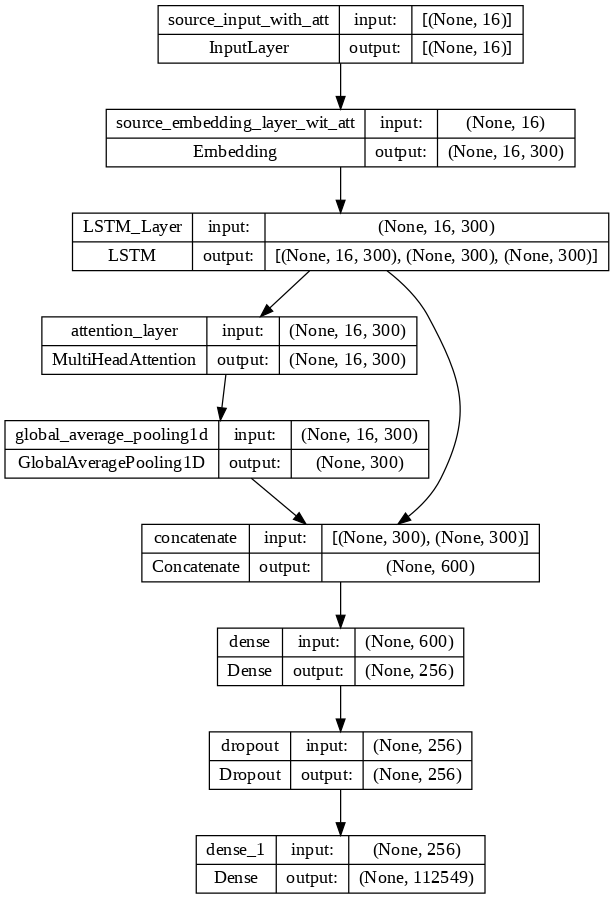

In [ ]:
keras.utils.plot_model(attention_lstm_model, show_shapes=True, dpi=90)

In [ ]:
attention_lstm_history = attention_lstm_model.fit(x_train,
                                    y_train,
                                    validation_split=0.1,
                                    batch_size=512,
                                    epochs=20)

Epoch 1/20
6677/6677 [==============================] - 885s 132ms/step - loss: 6.6334 - accuracy: 0.1277 - val_loss: 6.5509 - val_accuracy: 0.1339
Epoch 2/20
6677/6677 [==============================] - 882s 132ms/step - loss: 6.3813 - accuracy: 0.1345 - val_loss: 6.4827 - val_accuracy: 0.1389
Epoch 3/20
6677/6677 [==============================] - 876s 131ms/step - loss: 6.2481 - accuracy: 0.1385 - val_loss: 6.4622 - val_accuracy: 0.1413
Epoch 4/20
6677/6677 [==============================] - 876s 131ms/step - loss: 6.1459 - accuracy: 0.1414 - val_loss: 6.4653 - val_accuracy: 0.1429
Epoch 5/20
6677/6677 [==============================] - 875s 131ms/step - loss: 6.0574 - accuracy: 0.1442 - val_loss: 6.4606 - val_accuracy: 0.1438
Epoch 6/20
6677/6677 [==============================] - 875s 131ms/step - loss: 5.9765 - accuracy: 0.1467 - val_loss: 6.4721 - val_accuracy: 0.1452
Epoch 7/20
6677/6677 [==============================] - 874s 131ms/step - loss: 5.9021 - accuracy: 0.1492 - val_

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds[0], 1)
    return np.argmax(probas)

In [ ]:
# Define the start sentence
# sentence = 'i read in the news\nthat the average man\nplease kis'
# load model params:
# lstm_model = baseline_LSTM(lstm_dim=256,
#                 dense_layer_dim=256,
#                 embedding_input_dim=37261,
#                 embedding_output_dim=256,
#                 dropout_rate=0.2,
#                 embeddings_trainable=False)

# lstm_model.load_weights('../data/03_model_training/weights-improvement-20-3.3095-bigger.hdf5')

seq_length = 16
char_to_int = pop_char_to_int
int_to_char = pop_int_to_char
sentence = ["there's", "two", "things", "\n",
            "that", "i", 'have', "yet", "to", "learn", "\n",
            "how", "to", "forget", "or", "have"]

variance = .5
generated = []
original = sentence
window = sentence

for i in tqdm(range(100)):
    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = char_to_int[char] # Change the sentence to index vector shape (1,50)
        
    x_in = x
    pred = attention_lstm_model(x_in)
    next_index = sample(pred, variance)
    next_char = int_to_char[next_index] # index to char
    generated = generated + [next_char]
    window = window[1:] + [next_char] # Update Window for next char predict
print(" ".join(original + generated))
    

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


there's two things 
 that i have yet to learn 
 how to forget or have 
 
 I got the the the 
 I think that a that 
 I ain't I need and I want I never I know, 
 I love I know, I know, I know, I know, I know, I know, I know, 
 I know I know, I'm on I know I know, 
 I know, I know, I know, I know, I'm so 
 I know, I know, I know, I know I know, 
 I know, I know, I know, I know I know, I know, I know, I know, 
 I'm in Los Angeles I don't you


In [ ]:
# save model weights
attention_lstm_model.save_weights(f"{DATA_DIR}/03_model_training/rap_lstm_attention.h5")

# Super Seq2Seq

LSTM architecture using Skip Phrase Technique Music Generator

In [ ]:
# design the input:
# Encoder - Decoder Architecture
# Encoder (theoretically): 
#  1. encode the current line of lyric
#  2. encode the target line of lyric
#     - ideally, the next line would be the ideal line (except last line)
# Decoder:
#  1. attending between current line and the next line
#  2. feed through fully connected hidden layer
#  3. generate the next word

In [ ]:
# Let's use an array of UNK token as the first line for the x-train next
print('Unkown Token: ', pop_char_to_int['UNK'])
unk_arr = np.full((1, 16), pop_char_to_int['UNK'])
x_train_next = np.concatenate((x_train[1:], unk_arr)).astype(int)
x_train_next

Unkown Token:  32931


array([[31612, 32678, 30345, ..., 23139, 19732,     0],
       [32678, 30345, 20820, ..., 19732,     0,  8919],
       [30345, 20820, 23148, ...,     0,  8919, 21941],
       ...,
       [27500,     0, 11250, ..., 23139,     0,  4656],
       [    0, 11250, 19101, ...,     0,  4656, 14946],
       [32931, 32931, 32931, ..., 32931, 32931, 32931]])

In [ ]:
# Design Neural Network with Attention
def ED_LSTM(lstm_dim,
                  dense_layer_dim,
                  dropout_rate=0.2):
    """
        LSTM Layer with attention
    """
    
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # declare a source input
    # apply embedding layer to the input
    source_input_with_att = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), 
                                                  dtype='int64', 
                                                  name='source_input_with_att')
    
    target_input_with_att = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), 
                                                  dtype='int64', 
                                                  name='target_input_with_att')
    

    source_embeddings_with_att = tf.keras.layers.Embedding(input_dim = MAX_SEQUENCE_LENGTH,
                                                          output_dim = embedding_matrix.shape[1],
                                                          input_length=MAX_SEQUENCE_LENGTH,
                                                          trainable=False, 
                                                          name = 'source_embedding_layer_wit_att')
    
    target_embeddings_with_att = tf.keras.layers.Embedding(input_dim = MAX_SEQUENCE_LENGTH,
                                                          output_dim = embedding_matrix.shape[1],
                                                          input_length=MAX_SEQUENCE_LENGTH,
                                                          trainable=False, 
                                                          name = 'target_embedding_layer_att')

    
    # embedding
    src_embedding = source_embeddings_with_att(source_input_with_att)
    tgt_embedding = target_embeddings_with_att(target_input_with_att)


    # define the lstm layer for source and target
    encoder_lstm_layer_with_att = tf.keras.layers.LSTM(embedding_matrix.shape[1], 
                                                       return_sequences=True, 
                                                       return_state=True, 
                                                       name='encoder_lstm_layer_with_att')
    encoder_lstm_out_with_att, encoder_state_h_with_att, encoder_state_c_with_att = encoder_lstm_layer_with_att(src_embedding)

    decoder_lstm_layer_with_att = tf.keras.layers.LSTM(embedding_matrix.shape[1], 
                                                       go_backwards=True,
                                                       return_sequences=True, 
                                                       return_state=False, 
                                                       name='decoder_lstm_layer_with_att')
    decoder_lstm_out_with_att = decoder_lstm_layer_with_att(tgt_embedding, [encoder_state_h_with_att, encoder_state_c_with_att])

    attention_context_vectors  = tf.keras.layers.Attention(name="attention_layer")([decoder_lstm_out_with_att, encoder_lstm_out_with_att])
    
    
    # concatenate the decoder and encoder layer
    # Attention Mechanism to be feed into a fully connected Neural Net
    input_layer = tf.keras.layers.Concatenate(axis=1, name='concat_layer_with_att')([attention_context_vectors, decoder_lstm_out_with_att])
    
    # add some forward LSTM layers 
    # feed concatentation layer to 1 more LSTM layer
    # normalized the output
    # feed the normalized output to fully connected deep layer
    forward_lstm_layer = tf.keras.layers.LSTM(lstm_dim, recurrent_dropout=dropout_rate, name='forward_lstm_layer_2')    
    forward_output = forward_lstm_layer(input_layer)
    normalization_layer = keras.layers.BatchNormalization(name="normalize_1")
    normalized_output = normalization_layer(forward_output)
    last_hidden_output = normalized_output

    # add 2 dense layer (later?)
    last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    # perform batch normalization
    normalization_layer = keras.layers.BatchNormalization(name="normalize_2")
    normalized_output = normalization_layer(last_hidden_output)
    
    lstm_prediction = keras.layers.Dense(len(pop_words), activation='softmax')(normalized_output)

    lstm_model = keras.Model(inputs=[source_input_with_att, target_input_with_att], outputs=lstm_prediction)
    lstm_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return lstm_model

In [ ]:
encoder_decoder_lstm_model = ED_LSTM(lstm_dim=256,
                                    dense_layer_dim=256,
                                    dropout_rate=0.2)
encoder_decoder_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_input_with_att (InputLa  [(None, 16)]        0           []                               
 yer)                                                                                             
                                                                                                  
 target_input_with_att (InputLa  [(None, 16)]        0           []                               
 yer)                                                                                             
                                                                                                  
 source_embedding_layer_wit_att  (None, 16, 300)     4800        ['source_input_with_att[0][0]']  
  (Embedding)                                                                                 

In [ ]:
print(x_train.shape, x_train_next.shape)


(1323433, 16) (1323433, 16)


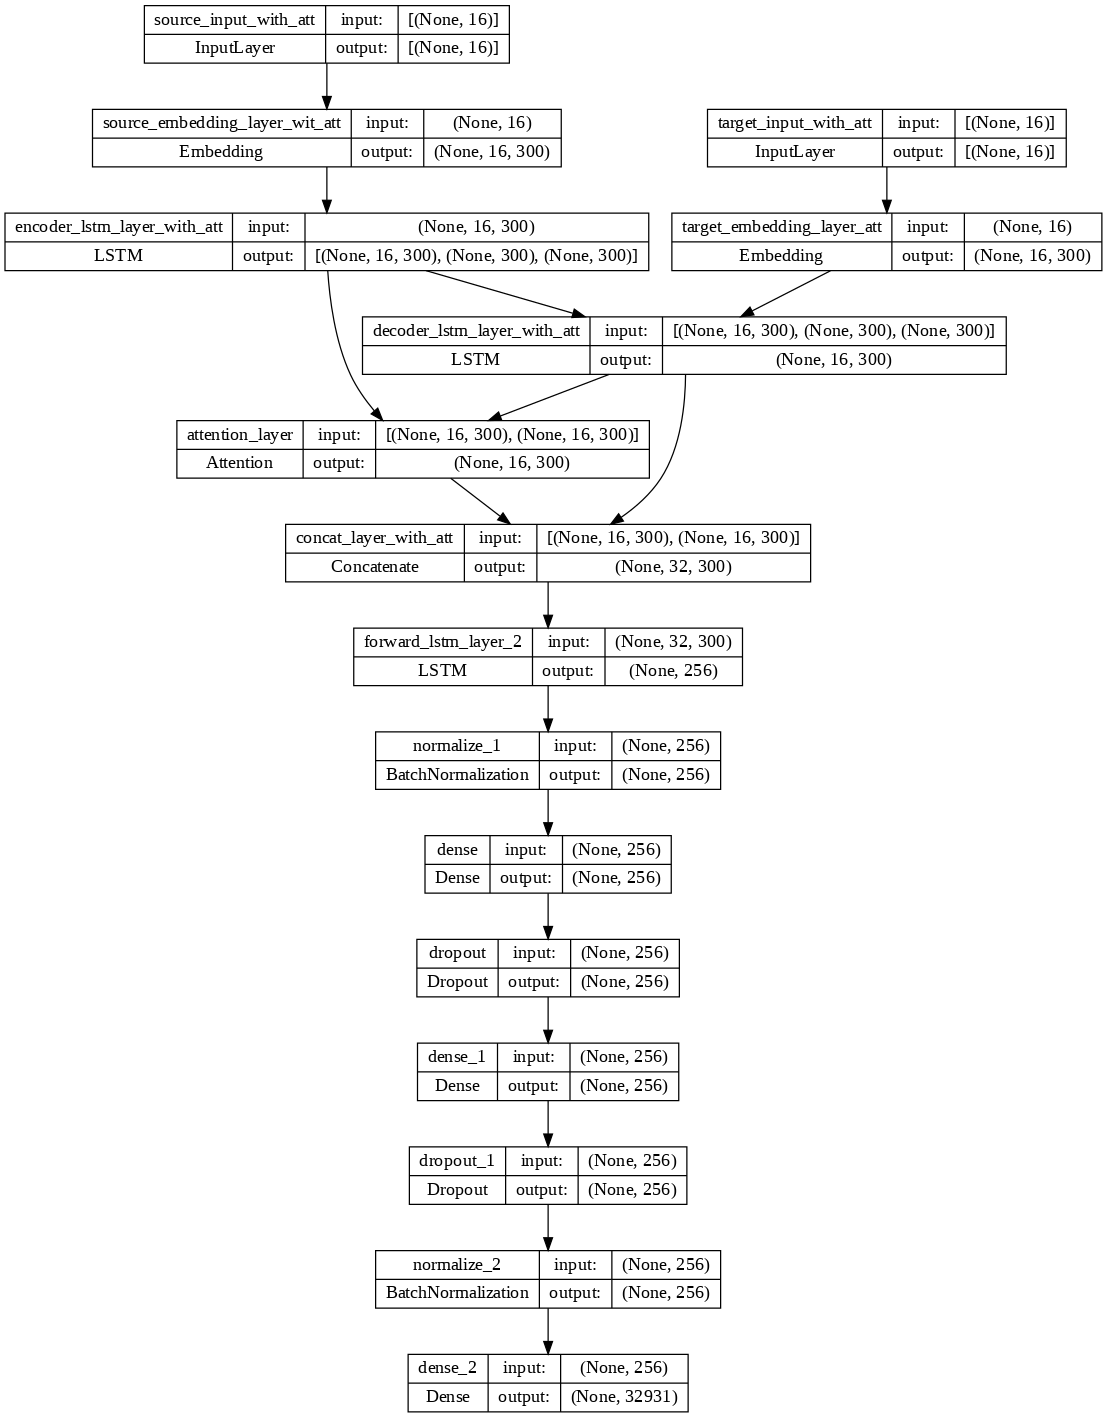

In [ ]:
keras.utils.plot_model(encoder_decoder_lstm_model, show_shapes=True, dpi=90)

In [ ]:
lstm_history = encoder_decoder_lstm_model.fit(x = [x_train, x_train_next],
                                                y = y_train,
                                                validation_split=0.1,
                                                batch_size=258,
                                                epochs=3)

Epoch 1/3
4617/4617 [==============================] - 493s 106ms/step - loss: 5.7382 - accuracy: 0.1792 - val_loss: 5.7779 - val_accuracy: 0.1787
Epoch 2/3
4617/4617 [==============================] - 485s 105ms/step - loss: 5.5846 - accuracy: 0.1815 - val_loss: 5.8162 - val_accuracy: 0.1799
Epoch 3/3
4617/4617 [==============================] - 483s 105ms/step - loss: 5.5443 - accuracy: 0.1818 - val_loss: 5.8084 - val_accuracy: 0.1801


# Test Generation

Testing Model Output Using 16 tokens seeds

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds[0], 1)
    return np.argmax(probas)

In [ ]:
# Define the start sentence
# sentence = 'i read in the news\nthat the average man\nplease kis'
# load model params:
# lstm_model = baseline_LSTM(lstm_dim=256,
#                 dense_layer_dim=256,
#                 embedding_input_dim=37261,
#                 embedding_output_dim=256,
#                 dropout_rate=0.2,
#                 embeddings_trainable=False)

# lstm_model.load_weights('../data/03_model_training/weights-improvement-20-3.3095-bigger.hdf5')

seq_length = 16
char_to_int = pop_char_to_int
int_to_char = pop_int_to_char
sentence_1 = ["there's", "two", "things", "\n",
              "that", "i", 'have', "yet", "to", "learn", "\n",
              "how", "to", "forget", "or", "have"]

sentence_2 = ["have", "i", "love", "someone", "\n",
              "all", "these", "time", "waiting", "\n",
              "have", "come", "suddenly", "when", "did", "i"]

variance = .5
generated = []
original = sentence_1 + sentence_2
window = [sentence_1, sentence_2]

for i in tqdm(range(300)):
    x_in = np.zeros((1, seq_length))
    x_in_next = np.zeros((1, seq_length))

    for i in range(seq_length):


        x_in[0, i] = char_to_int[sentence_1[i]] # Change the sentence to index vector shape (1,50)
        x_in_next[0, i] = char_to_int[sentence_2[i]] # Change the sentence to index vector shape (1,50)

    
    pred = encoder_decoder_lstm_model([x_in, x_in_next])
    next_index = sample(pred, variance)
    next_char = int_to_char[next_index] # index to char
    generated = generated + [next_char]
    
    
    sentence_1 = sentence_1[1:] + [sentence_2[0]]
    sentence_2 = sentence_2[1:] + [next_char]
    
#     print(i, sentence_1, sentence_2)
#     print("\n")
          
print(" ".join(original + generated))
    

  0%|          | 0/300 [00:00<?, ?it/s]

there's two things 
 that i have yet to learn 
 how to forget or have have i love someone 
 all these time waiting 
 have come suddenly when did i get baby to you me But our the all it Get don't to to you a you you you me you oh and in is the you you free me to me a you the it on and a to a a of to to and me the do ? you the good and you to I boy you a ? you the me to you feel ? hey you from the ? baby day you in there in the ? the a ? a my ? the I the make ? out love to even it you day the me the ? a to me that this the on of up you the the ? the world her me my her you baby) to the and to of it my the you me in ? you ? the of me of a you ? ? ? but yeah a ? of more be to you you you at her you no of ? the to you ? bad you to I you the it to is do in me oh long to to of we're the mine of ? the me me ? to just I be of it and ? just and ? the a ? your to in and it of the is my out in it to go of feel and you ? but ? to to to to me in you the ? and car, ? I on a you and of ? a her to time

In [ ]:
encoder_decoder_lstm_model.save_weights(f"{DATA_DIR}/03_model_training/rnb_super_lstm_attention.h5")

## Graveyard
Spooky code beyond this point

In [ ]:
# # Design Neural Network without Attention
# def baseline_LSTM(lstm_dim,
#                 dense_layer_dim,
#                 dropout_rate=0.2):
#     """
#         LSTM Layer with attention
#     """
    
#     tf.keras.backend.clear_session()
#     np.random.seed(0)
#     tf.random.set_seed(0)

#     # declare a source input
#     # apply embedding layer to the input
#     source_input_with_att = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), 
#                                                   dtype='int64', 
#                                                   name='source_input_with_att')
    

#     source_embeddings_with_att = tf.keras.layers.Embedding(input_dim = embedding_matrix.shape[0],
#                                                           output_dim = embedding_matrix.shape[1],
#                                                           embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
#                                                           input_length=MAX_SEQUENCE_LENGTH,
#                                                           trainable=False, 
#                                                           name = 'source_embedding_layer_wit_att')

#     src_embedding = source_embeddings_with_att(source_input_with_att)


#     # define a query layer:
#     # utilizing a fake input layer of 1 to get a query vector 
#     query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
#     one_vector = tf.Variable(tf.ones((1, 1, 1)))
#     batch_of_ones = tf.tile(one_vector, (tf.shape(source_input_with_att)[0], 1, 1))
#     query_vector = query_layer(batch_of_ones)

#     # define the lstm layer
#     encoder_lstm_layer_with_att = tf.keras.layers.LSTM(embedding_matrix.shape[1], return_sequences=True, return_state=True, recurrent_dropout=dropout_rate,name='LSTM_Layer')
#     encoder_out_with_att, encoder_state_h_with_att, encoder_state_c_with_att = encoder_lstm_layer_with_att(src_embedding)


#     attention_output  = tf.keras.layers.Attention()([query_vector, encoder_out_with_att])
#     query_vector = tf.keras.layers.Reshape((query_vector.shape[-1],), name='query_vector')(query_vector)
#     context_vector = tf.keras.layers.Reshape((attention_output.shape[-1],), name='attention_context_vector')(attention_output)

#     # concatenate the context vector and query vector
#     # Attention Mechanism to be feed into a fully connected Neural Net
#     input_layer = tf.keras.layers.Concatenate()([context_vector, query_vector])
#     last_hidden_output = input_layer

#     # add 1 dense layer (later?)
#     last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
#     last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)

#     lstm_prediction = keras.layers.Dense(len(pop_words), activation='softmax')(last_hidden_output)

#     lstm_model = keras.Model(inputs=source_input_with_att, outputs=lstm_prediction)
#     lstm_model.compile(optimizer='adam',
#                       loss='sparse_categorical_crossentropy',  # From information theory notebooks.
#                       metrics=['accuracy'])
#     return lstm_model